In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd /home/mabitbol/GBT-S140/analysis/

/home/mabitbol/GBT-S140/analysis


In [3]:
import foregrounds as fg
from scipy.optimize import curve_fit
import emcee
import corner

In [61]:
from __future__ import unicode_literals

figsize(16, 10)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 0
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 0
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 24
rcParams['legend.borderaxespad'] = 1

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24
rcParams['axes.labelpad'] = 10

In [5]:
bigfs = np.array([  4.08000000e+08,   1.42000000e+09,   4.57500000e+09,
         5.62500000e+09,   6.12500000e+09,   2.84000000e+10,
         4.41000000e+10,   7.04000000e+10,   1.43000000e+11,
         2.17000000e+11,   3.53000000e+11,   5.45000000e+11,
         8.57000000e+11,   1.25000000e+12,   2.14200000e+12])

In [6]:
bigdata = np.array([  1.69932098e+01,   1.88907320e+01,   1.80860056e+01,
         1.75061433e+01,   1.77466662e+01,   3.02925356e+01,
         2.67933107e+01,   2.61128183e+01,   9.05264927e+01,
         4.16199852e+02,   1.72719297e+03,   5.70690360e+03,
         1.84255235e+04,   4.13180614e+04,   6.93541594e+04])

In [7]:
bigerrs = np.array([  2.63219005e+00,   1.98121311e+00,   2.00000000e+00,
         2.00000000e+00,   2.00000000e+00,   1.16505200e+00,
         1.09064996e+00,   1.29007422e+00,   4.98904303e+00,
         1.98394742e+01,   7.92722760e+01,   2.50315395e+02,
         7.56000198e+02,   1.08024285e+03,   1.45376870e+03])

In [8]:
beam = pi*((45./60.)*pi/180.)**2
beam2 = pi*((1./60./60.)*pi/180.)**2

In [9]:
def signal(freqs, EM, Asd, nup, Ad, Bd, Td, Acmb):
    fffit = fg.freefreep(freqs, EM=EM, Te=8000)
    amefit = fg.ame(freqs, Asd=Asd, nup=nup) 
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=Td)
    ccmb = fg.cmb(freqs, A=Acmb)
    return (fffit + dustfit + amefit + ccmb) * beam

In [10]:
def signal2(freqs, EM1, EM2, abeam, Ad, Bd, Td, Acmb):
    fffit = fg.freefreep(freqs, EM=EM1, Te=8000) * beam
    fffit2 = fg.freefreep(freqs, EM=EM2, Te=8000) * abeam
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=Td) * beam
    ccmb = fg.cmb(freqs, A=Acmb) * beam
    return fffit + fffit2 + dustfit + ccmb

In [11]:
pn = np.array([100., 1.e-3, 30.e9, 1.e-4, 2., 20., 30.e-6])
x = curve_fit(signal, bigfs, bigdata, p0=pn, sigma=bigerrs, absolute_sigma=True)
pfit3 = x[0]

In [12]:
pn2 = np.array([100., 1.e9, 5.e-10, 1.e-4, 2., 20., 30e-6])
y = curve_fit(signal2, bigfs, bigdata, p0=pn2, sigma=bigerrs, absolute_sigma=True)
pfit4 = y[0]

In [13]:
print "EM, Asd, nup, Ad, Bd, Td, Acmb"
print pfit3

EM, Asd, nup, Ad, Bd, Td, Acmb
[  3.48066890e+02   1.38033227e-03   3.27025594e+10   1.18803225e-03
   1.46664344e+00   2.35684628e+01   2.98412618e-05]


In [14]:
print "EM1, EM2, abeam, Ad, Bd, Td, Acmb"
print pfit4

EM1, EM2, abeam, Ad, Bd, Td, Acmb
[  3.04280679e+02   7.41276037e+08   4.17236735e-10   1.22863834e-03
   1.28690403e+00   2.56155126e+01  -2.23041016e-04]


In [15]:
np.sqrt(pfit4[2] / pi) * 180. / pi * 60.

0.039617787238266804

In [16]:
figsize(8, 6)

In [17]:
def lnprior2(theta):
    EM1, EM2, abeam, Ad, Bd, Td, Acmb = theta
    if EM1 < 0 or EM1 > 1e4:
        return np.inf
    if EM2 < 1e4 or EM2 > 1e11:
        return np.inf
    if abeam < 0 or abeam > 1e-5:
        return np.inf
    if Ad < 0 or Ad > 10:
        return np.inf
    if Bd < 0 or Bd > 10:
        return np.inf
    if Td < 1 or Td > 100:
        return np.inf
    if np.abs(Acmb) > 10:
        return np.inf
    return 0.

In [18]:
def lnprob2(theta, x, y, yerr):
    lp = lnprior2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike2(theta, x, y, yerr)

In [19]:
def lnlike2(theta, x, y, yerr):
    EM1, EM2, abeam, Ad, Bd, Td, Acmb = theta
    fffit = fg.freefreep(x, EM=EM1, Te=8000.) * beam
    fffit2 = fg.freefreep(x, EM=EM2, Te=8000.) * abeam
    dustfit = fg.thermal_dust(x, Ad=Ad, Bd=Bd, Td=Td) * beam
    ccmb = fg.cmb(x, A=Acmb) * beam
    model = fffit + fffit2 + dustfit + ccmb
    return -0.5 * np.sum((y-model)**2 / (yerr**2))

In [20]:
ndim, nwalkers = 7, 128
pos = [pfit4 * (1. + 1.e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [21]:
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(bigfs, bigdata, bigerrs))

In [22]:
sampler1.run_mcmc(pos, 2**16);

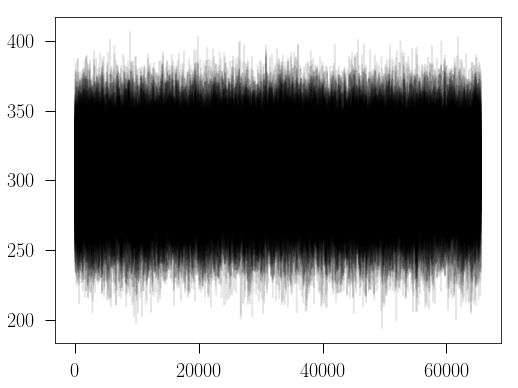

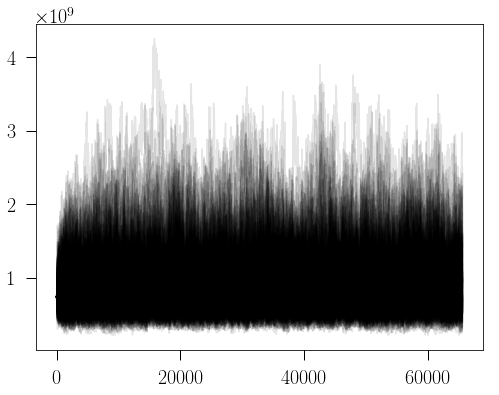

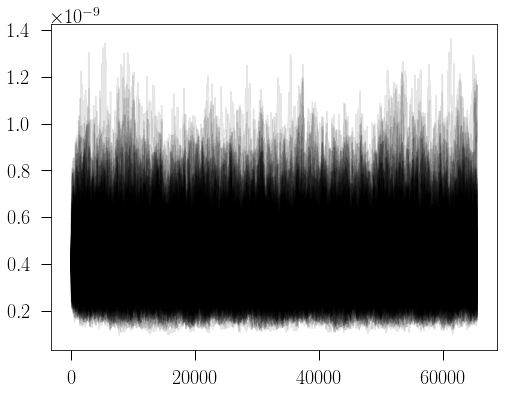

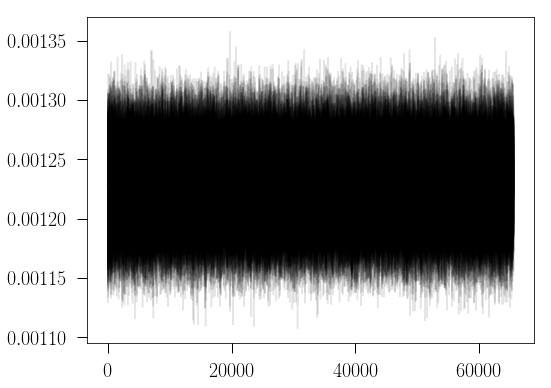

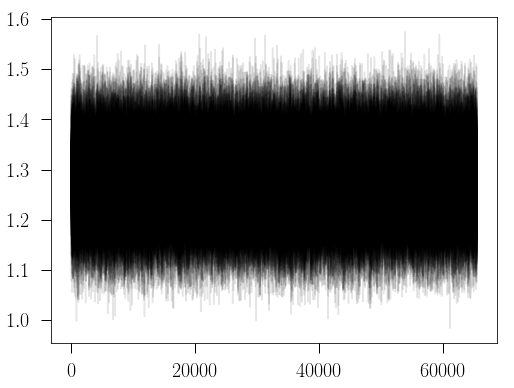

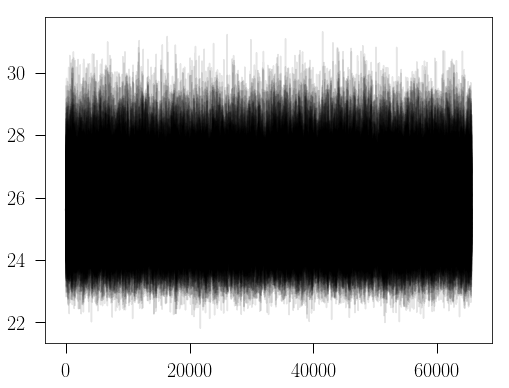

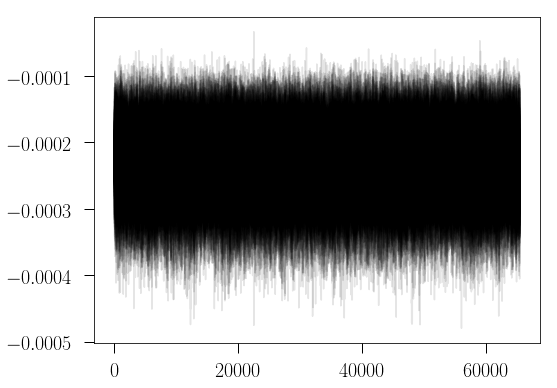

In [23]:
for k in range(ndim):
    figure()
    plot(sampler1.chain[:,:,k].T, color='k', alpha=0.1);

In [24]:
samples1 = sampler1.chain[:, 5000:, :].reshape((-1, ndim))

In [53]:
datas = samples1.copy()

In [54]:
datas[:, 1] *= 1e-9
datas[:, 2] = np.sqrt( datas[:, 2] / pi) * 180. / pi * 60. * 60.
datas[:, 3] *= 1e6
datas[:, 6] *= 1e6

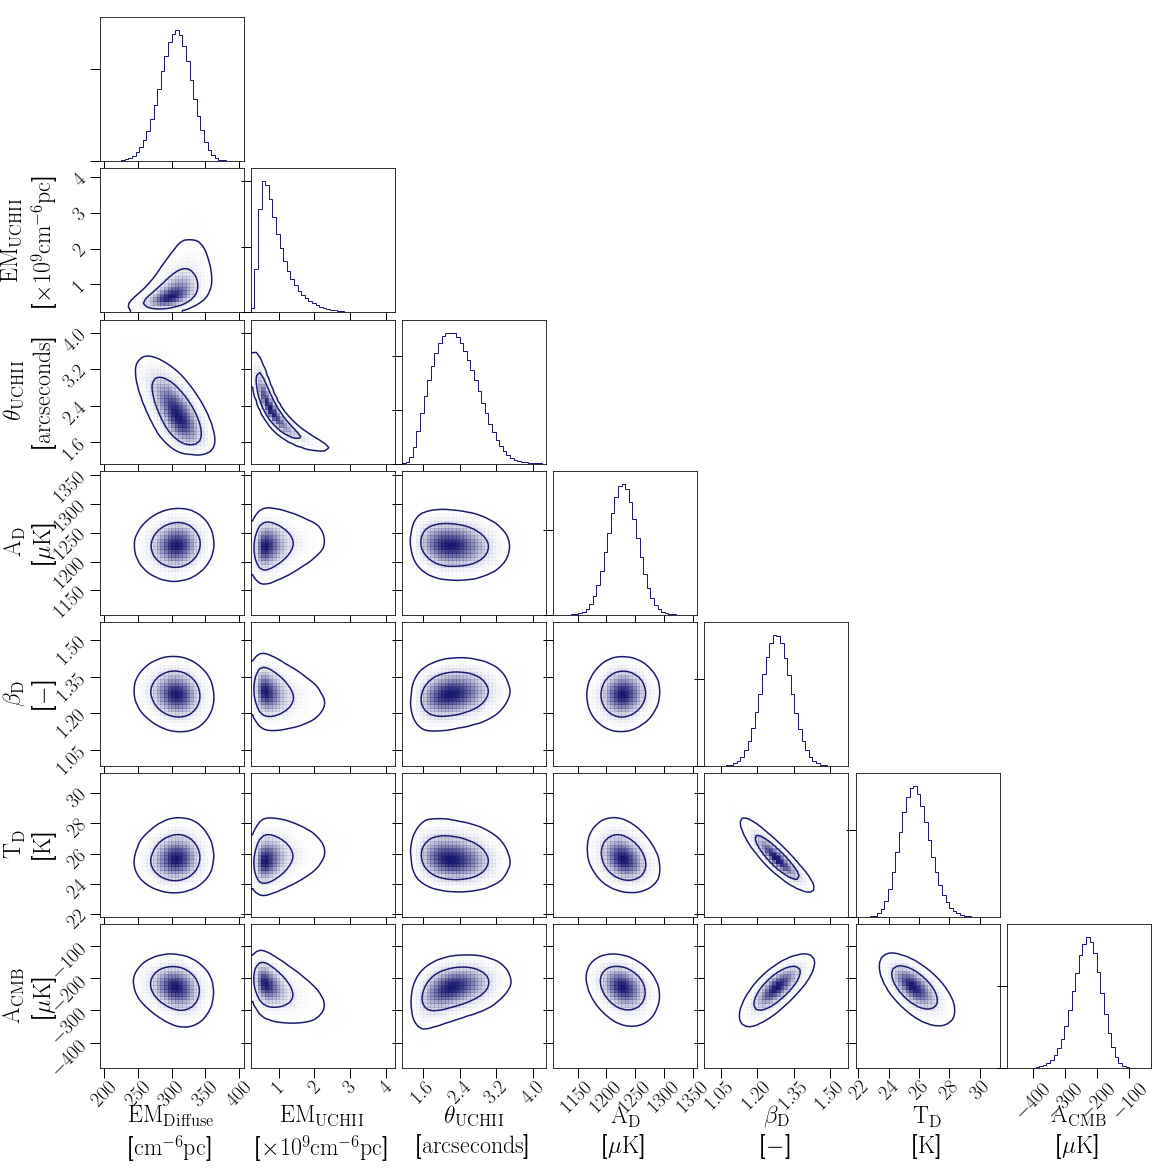

In [91]:
fig = corner.corner(datas, plot_datapoints=False, bins=40, levels=[0.68,0.95], smooth=1.,\
                    labels=["$\mathrm{EM_{Diffuse}}$\n [$\mathrm{cm^{-6} pc}$]", 
                            "$\mathrm{EM_{UCHII}}$\n [$\\times 10^9 \mathrm{cm^{-6} pc}$]", 
                            "$\mathrm{\\theta_{UCHII}}$\n [$\mathrm{arcseconds}$]",
                            "$\mathrm{A_{D}}$\n [$\mathrm{\mu K}$]", 
                            "$\mathrm{\\beta_{D}}$\n [$-$]", 
                            "$\mathrm{T_{D}}$\n [$\mathrm{K}$]", 
                            "$\mathrm{A_{CMB}}$\n [$\mathrm{\mu K}$]"], \
                    color='midnightblue', label_kwargs={'labelpad':5})
savefig('/home/mabitbol/GBT-S140/notebooks/UCHII_posterior.pdf', format='pdf', bbox_inches='tight')

In [65]:
print "EM1, EM2, abeam, Ad, Bd, Td, Acmb"
print pfit4
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples1, [16, 50, 84], axis=0)))

EM1, EM2, abeam, Ad, Bd, Td, Acmb
[  3.04280679e+02   7.41276037e+08   4.17236735e-10   1.22863834e-03
   1.28690403e+00   2.56155126e+01  -2.23041016e-04]


[(306.23712236576318, 22.509709774251689, 23.890503709713698),
 (810054202.00885153, 523524793.14722252, 279964356.9467417),
 (3.8373833709755326e-10, 1.9338759706908061e-10, 1.3705126375295084e-10),
 (0.0012286640701498323, 2.4875932201922366e-05, 2.4642534725194745e-05),
 (1.2790190290514289, 0.060318903261068035, 0.060199752672947415),
 (25.726979543406202, 1.0175722981278277, 0.93146447131411136),
 (-0.00023076590399371161, 4.1738951279045783e-05, 4.5088719590085312e-05)]

In [66]:
np.sqrt(np.array([3.8373833709755326e-10, 1.9338759706908061e-10, 1.3705126375295084e-10]) / pi) * 180. / pi * 60. * 60.

array([ 2.27964799,  1.61832039,  1.36235948])

In [68]:
print "EM1, EM2, abeam, Ad, Bd, Td, Acmb"
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(datas, [16, 50, 84], axis=0)))

EM1, EM2, abeam, Ad, Bd, Td, Acmb


[(306.23712236576318, 22.509709774251689, 23.890503709713698),
 (0.81005420200885159, 0.52352479314722256, 0.27996435694674171),
 (2.2796479926345068, 0.51601934220387546, 0.4518702136455035),
 (1228.6640701498322, 24.875932201922524, 24.642534725194764),
 (1.2790190290514289, 0.060318903261068035, 0.060199752672947415),
 (25.726979543406202, 1.0175722981278277, 0.93146447131411136),
 (-230.76590399371162, 41.738951279045779, 45.088719590085304)]

In [71]:
def lnprior(theta):
    EM, Asd, nup, Ad, Bd, Td, Acmb = theta
    if EM < 0 or EM > 1e9:
        return np.inf
    if Asd < 0 or Asd > 1e3:
        return np.inf
    if nup < 1e9 or nup > 1e11:
        return np.inf
    if Ad < 0 or Ad > 1e3:
        return np.inf
    if Bd < 0 or Bd > 100:
        return np.inf
    if Td < 0 or Td > 1000:
        return np.inf
    if np.abs(Acmb) > 1e3:
        return np.inf
    return 0.

In [72]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [73]:
def lnlike(theta, x, y, yerr):
    EM, Asd, nup, Ad, Bd, Td, Acmb = theta
    fffit = fg.freefreep(x, EM=EM, Te=8000.)
    dustfit = fg.thermal_dust(x, Ad=Ad, Bd=Bd, Td=Td)
    amefit = fg.ame(x, Asd=Asd, nup=nup) 
    ccmb = fg.cmb(x, A=Acmb)
    model = (fffit + dustfit + amefit + ccmb) * beam
    return -0.5 * (np.sum((y - model)**2. * yerr**-2.))

In [74]:
ndim, nwalkers = 7, 64
pos = [pfit3 * (1. + 1.e-2*np.random.randn(ndim)) for i in range(nwalkers)]

In [75]:
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(bigfs, bigdata, bigerrs))

In [76]:
sampler2.run_mcmc(pos, 2**14);

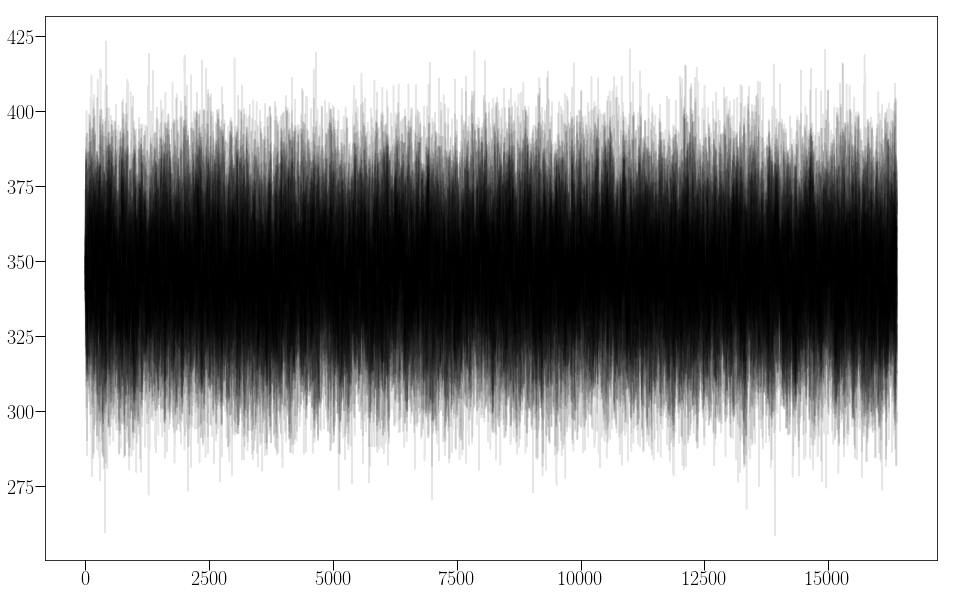

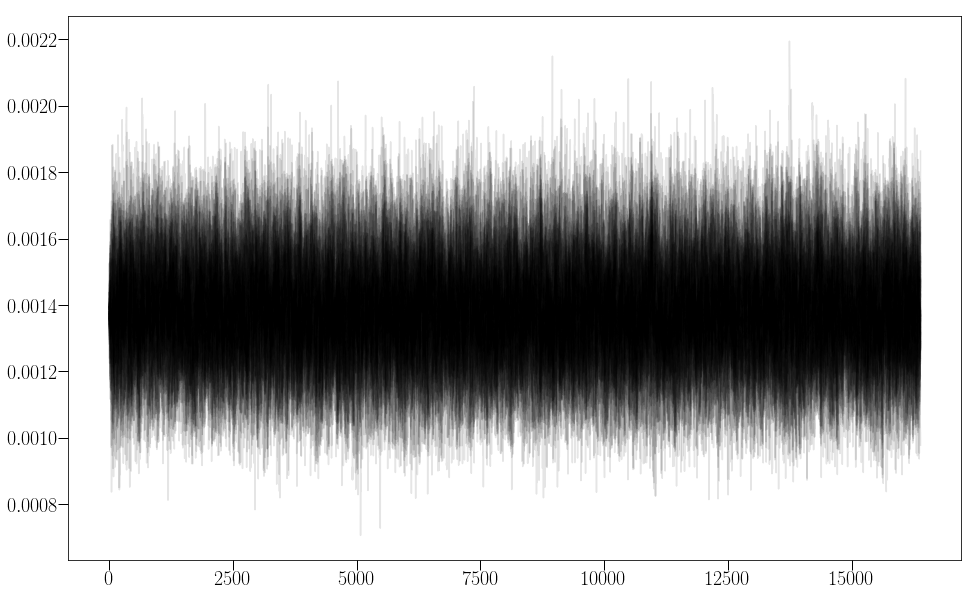

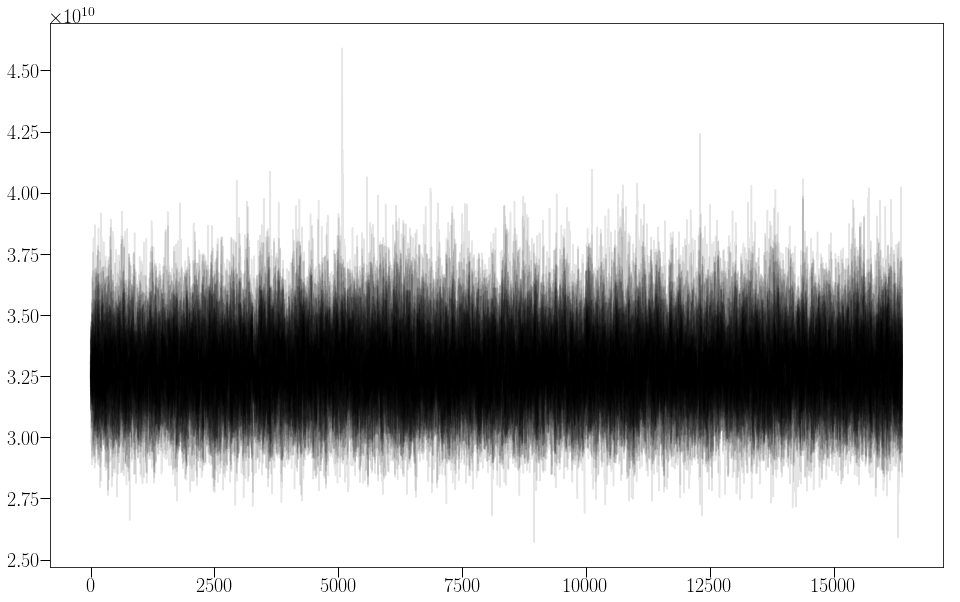

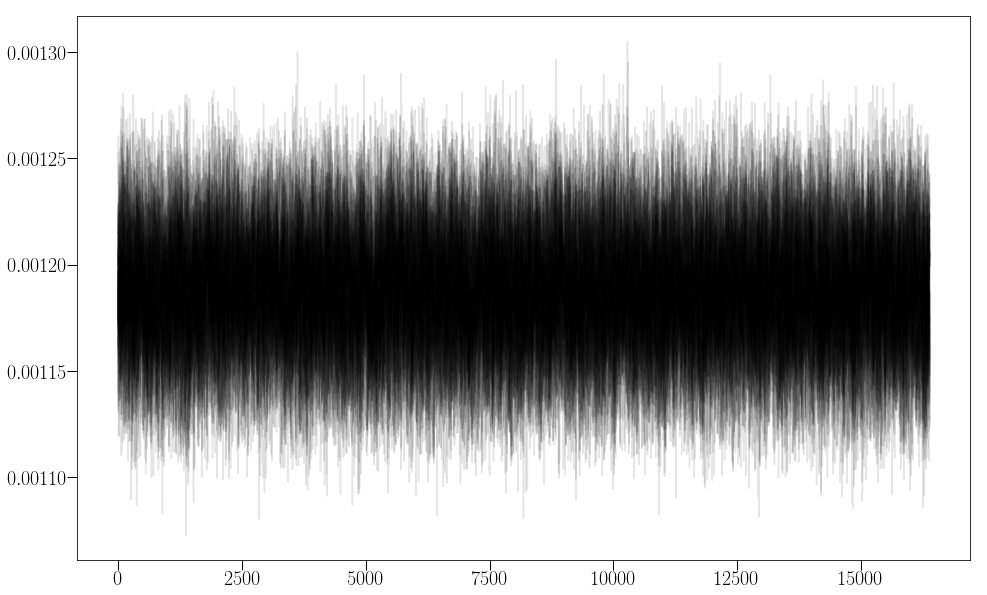

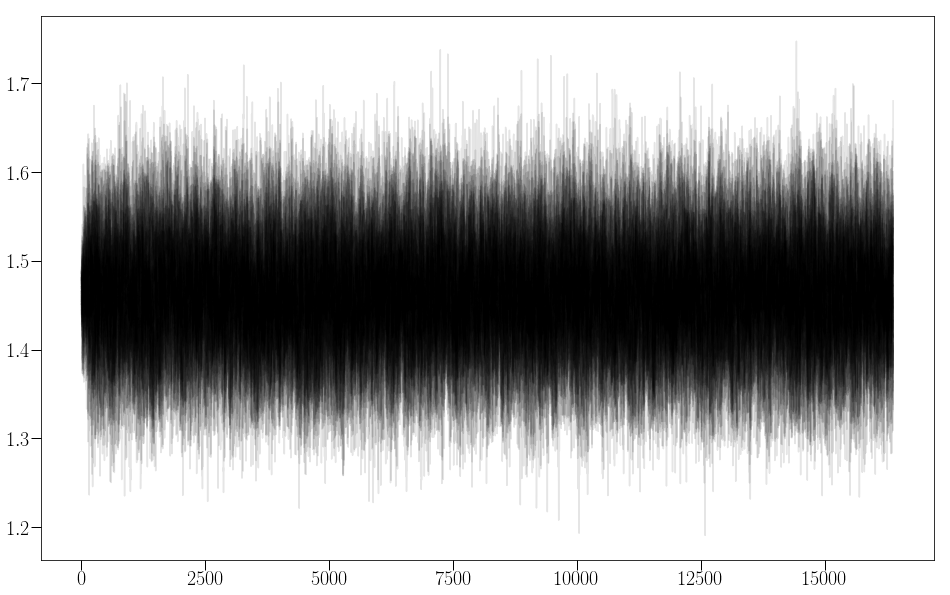

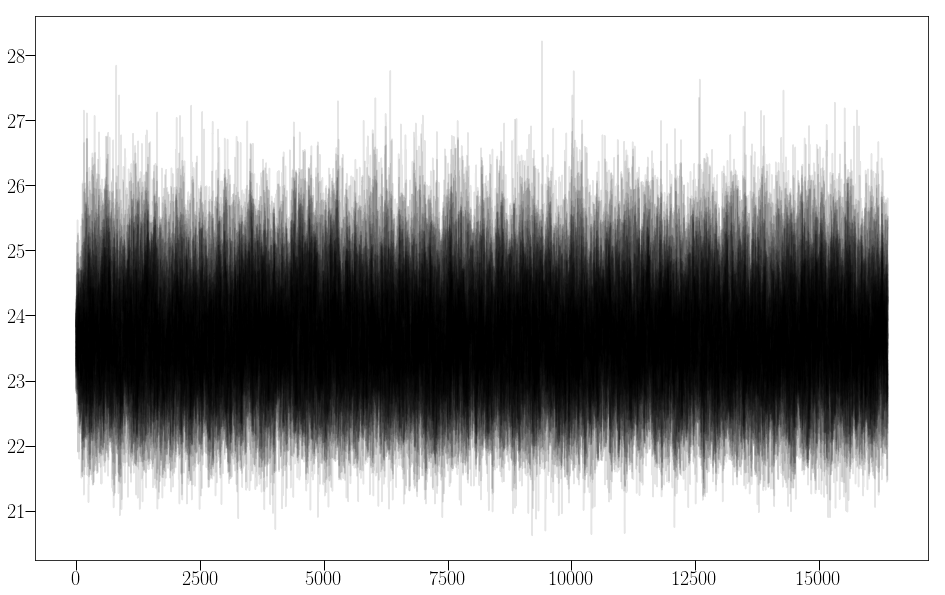

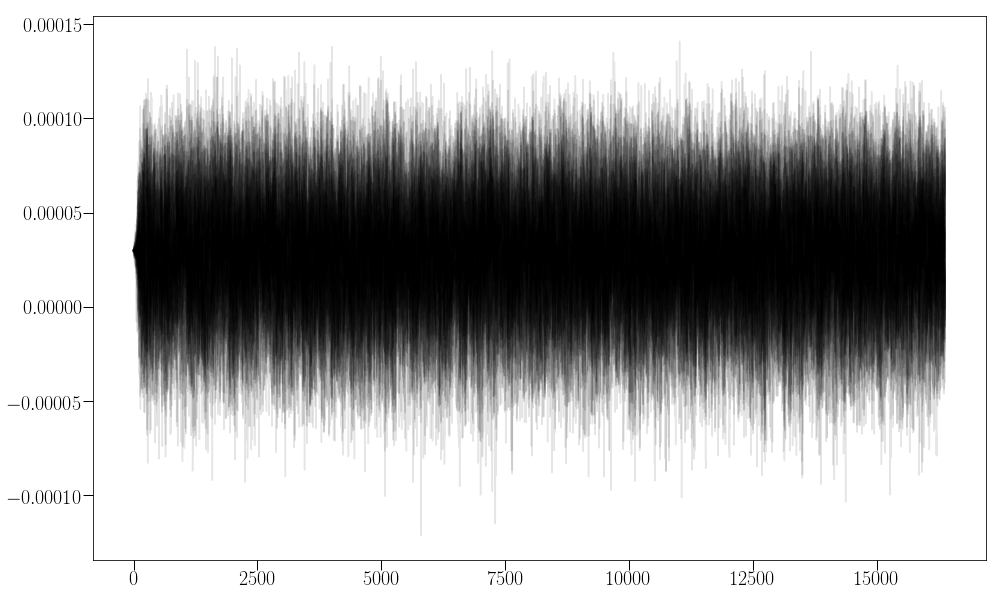

In [78]:
for k in range(ndim):
    figure()
    plot(sampler2.chain[:,:,k].T, color='k', alpha=0.1);

In [79]:
samples2 = sampler2.chain[:, 4000:, :].reshape((-1, ndim))

In [80]:
datas2 = samples2.copy()

In [81]:
datas2[:, 1] *= 1e6
datas2[:, 2] *= 1e-9
datas2[:, 3] *= 1e6
datas2[:, 6] *= 1e6

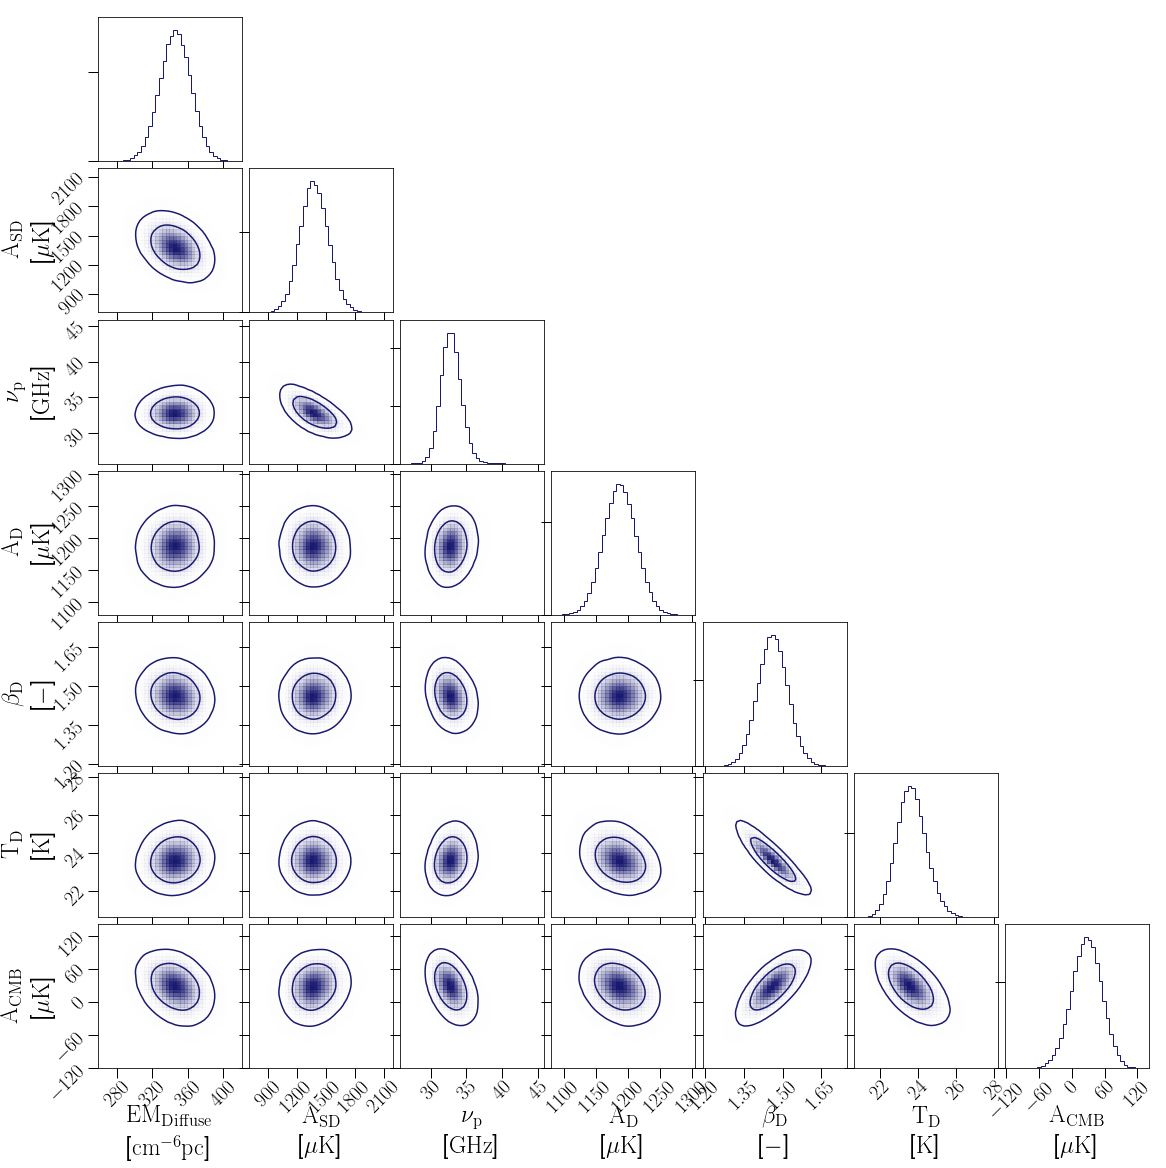

In [90]:
fig = corner.corner(datas2, plot_datapoints=False, bins=40, levels=[0.68,0.95], smooth=1.,\
                    labels=["$\mathrm{EM_{Diffuse}}$\n [$\mathrm{cm^{-6} pc}$]", 
                            "$\mathrm{A_{SD}}$\n [$\mathrm{\mu K}$]", 
                            "$\mathrm{\\nu_{p}}$\n [$\mathrm{GHz}$]",
                            "$\mathrm{A_{D}}$\n [$\mathrm{\mu K}$]", 
                            "$\mathrm{\\beta_{D}}$\n [$-$]", 
                            "$\mathrm{T_{D}}$\n [$\mathrm{K}$]", 
                            "$\mathrm{A_{CMB}}$\n [$\mathrm{\mu K}$]"], \
                    color='midnightblue', label_kwargs={'labelpad':5})
savefig('/home/mabitbol/GBT-S140/notebooks/spinningdust_posterior.pdf', format='pdf', bbox_inches='tight')

In [83]:
print "EM, Asd, nup, Ad, Bd, Td, Acmb"
print pfit3
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples2, [16, 50, 84], axis=0)))

EM, Asd, nup, Ad, Bd, Td, Acmb
[  3.48066890e+02   1.38033227e-03   3.27025594e+10   1.18803225e-03
   1.46664344e+00   2.35684628e+01   2.98412618e-05]


[(345.90486417854333, 17.354870356843037, 17.585123719964145),
 (0.0013767379100528407, 0.00014816394941608696, 0.00014182026009630774),
 (32796072902.899761, 1424403370.7040634, 1336935260.8112335),
 (0.0011871558668354698, 2.5226901455993557e-05, 2.5058886606486907e-05),
 (1.4610879393672045, 0.057316880510011048, 0.056888485412992074),
 (23.636089014455845, 0.79160503312355601, 0.73839824219030348),
 (2.7343214079110066e-05, 2.7002190070328197e-05, 2.7695483654515521e-05)]

In [85]:
print "EM, Asd, nup, Ad, Bd, Td, Acmb"
print pfit3
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(datas2, [16, 50, 84], axis=0)))

EM, Asd, nup, Ad, Bd, Td, Acmb
[  3.48066890e+02   1.38033227e-03   3.27025594e+10   1.18803225e-03
   1.46664344e+00   2.35684628e+01   2.98412618e-05]


[(345.90486417854333, 17.354870356843037, 17.585123719964145),
 (1376.7379100528406, 148.16394941608701, 141.82026009630772),
 (32.796072902899766, 1.4244033707040629, 1.3369352608112379),
 (1187.1558668354699, 25.226901455993584, 25.058886606487022),
 (1.4610879393672045, 0.057316880510011048, 0.056888485412992074),
 (23.636089014455845, 0.79160503312355601, 0.73839824219030348),
 (27.343214079110069, 27.00219007032819, 27.695483654515524)]